<a href="https://colab.research.google.com/github/prem-cre/Multirag/blob/main/citation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install all required libraries
!pip install -qU langchain langgraph langchain_groq langchain_huggingface
!pip install -qU faiss-cpu pypdf tiktoken
!pip install -qU langchain-community
!pip install -qU wikipedia
!pip install -qU langchain-google-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the so

In [3]:
# @title Configure API Keys, LLM, and FAISS Vector Store
import os
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('groq_api_key')

from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings


llm = ChatGroq(model_name="gemma2-9b-it", temperature=0)


embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L12-v2")

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

def read_documents(directory_path: str):
    """Loads PDF documents from a specified directory."""
    loader = PyPDFDirectoryLoader(directory_path)
    documents = loader.load()
    print(f"Files found by PyPDFDirectoryLoader: {[doc.metadata.get('source') for doc in documents]}") # Added print statement
    return documents

def chunk_data(docs, chunk_size=1100, chunk_overlap=70):
    """Splits documents into smaller chunks."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(docs)
    return chunks

# Load, chunk, and index the documents
print("Loading documents that are uploaded...")
docs = read_documents('/content/')
print(f"Documents loaded before chunking: {docs}")
documents = chunk_data(docs)
print(f"Total chunks created: {len(documents)}")


print("Creating FAISS vector store...")
vector_store = None # Initialize vector_store to None
retriever = None # Initialize retriever to None

if documents: # Check if the documents list is not empty
    vector_store = FAISS.from_documents(documents, embeddings)
    retriever = vector_store.as_retriever()
    print("FAISS vector store and retriever are ready.")
else:
    print("No documents loaded or chunked. Skipping FAISS vector store creation.")


# Test the retriever
test_query = 'How does the radical separation of law and religion contribute to the integrity crisis in Western civilization, and can reintegrating their underlying values restore societal cohesion without compromising secular governance?'
if retriever: # Check if retriever is not None before invoking
    retrieved_docs = retriever.invoke(test_query)
    print(retrieved_docs)
    print(f"\n✅ Retriever test successful. Found {len(retrieved_docs)} related docs.")
    # print(retrieved_docs[0].page_content)
else:
    print("\nSkipping retriever test as no documents were loaded.")

Loading documents that are uploaded...
Files found by PyPDFDirectoryLoader: []
Documents loaded before chunking: []
Total chunks created: 0
Creating FAISS vector store...
No documents loaded or chunked. Skipping FAISS vector store creation.

Skipping retriever test as no documents were loaded.


In [4]:
# @title Define Real API Tools and Reranking Logic
import os
from google.colab import userdata
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_core.documents import Document
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from typing import List # Import List

# --- 1. Wikipedia Tool (Other APIs Stand-in) ---
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=1000)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

def other_apis_call(question: str) -> List[Document]:
    """Calls Wikipedia API for general knowledge as a stand-in for 'Other APIs'."""
    print("---(API Call): Calling Wikipedia API---")
    try:
        wiki_docs_raw = wikipedia_tool.invoke(question)
        # WikipediaQueryRun returns a string, so we need to wrap it
        return [Document(page_content=wiki_docs_raw, metadata={"source": "Wikipedia"})]
    except Exception as e:
        print(f"Error calling Wikipedia: {e}")
        return []


os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_CSE_ID"] = userdata.get('GOOGLE_CSE_ID')
google_search_wrapper = GoogleSearchAPIWrapper(k=7)

def kannon_api_call(question: str) -> List[Document]:
    """Calls Google Search API for specialized legal search as a stand-in for 'Kannon API'."""
    print("---(API Call): Calling Google Search (Kannon API Stand-in)---")
    try:
        search_results = google_search_wrapper.results(question, num_results=7)
        docs = []
        for res in search_results:
            docs.append(Document(
                page_content=f"Title: {res.get('title', 'N/A')}\nSnippet: {res.get('snippet', 'N/A')}",
                metadata={"source": "Google Search", "link": res.get('link', 'N/A')}
            ))
        return docs
    except Exception as e:
        print(f"Error calling Google Search: {e}")
        return []

# --- 3. Reranking Logic ---
def semantic_rerank(query: str, documents: List[Document], top_k: int = 5) -> List[Document]:
    """
    Reranks documents based on semantic similarity to the query using embeddings.
    Returns the top_k most relevant documents.
    """
    if not documents:
        return []

    print(f"---(Rerank): Reranking {len(documents)} documents for top {top_k}---")
    query_embedding = embeddings.embed_query(query)
    doc_embeddings = embeddings.embed_documents([doc.page_content for doc in documents])

    similarities = cosine_similarity([query_embedding], doc_embeddings)[0]
    ranked_indices = np.argsort(similarities)[::-1] # Sort descending

    top_k_docs = [documents[i] for i in ranked_indices[:top_k]]
    return top_k_docs

In [5]:
# @title Define Graph State and Nodes (Updated for Real APIs and Citations)
from typing import List, TypedDict, Dict, Any
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field # For structured output
from langchain_core.documents import Document # Import Document
from langchain_core.messages import HumanMessage, SystemMessage # Import message types

# --- 1. DEFINE GRAPH STATE ---
class Citation(BaseModel):
    """A citation for a generated legal statement."""
    source: str = Field(description="The source of the information (e.g., 'Wikipedia', 'FAISS DB', 'Google Search').")
    description: str = Field(description="A brief description of the content from the source.")
    link: str = Field(default=None, description="Optional: A URL link to the source if available.")

class GenerationWithCitations(BaseModel):
    """The final legal answer with supporting citations."""
    answer: str = Field(description="The comprehensive legal answer to the user's query.")
    citations: List[Citation] = Field(description="A list of relevant citations that support the answer. Provide citations for *any* factual information used from the context, even if the overall answer is that the information is not sufficient.")

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: The user's query.
        doc_uploaded: A boolean flag indicating if documents are part of the context.
        documents: A list of retrieved documents (from VectorDB or APIs).
        generation: The final, refined answer from the LLM (potentially a GenerationWithCitations object or string).
        # Removed user_feedback
    """
    question: str
    doc_uploaded: bool
    documents: List[Document]
    generation: Any # Allow for structured output or string


# --- 2. DEFINE GRAPH NODES ---

def retrieve_from_vector_db(state: GraphState) -> Dict[str, Any]:
    """Node to retrieve documents from the FAISS vector store."""
    print("---(Node): Retrieving from Vector DB---")
    question = state["question"]
    docs = retriever.invoke(question) # Already configured to get top 5
    return {"documents": docs}

def call_apis(state: GraphState) -> Dict[str, Any]:
    """Node that runs API calls and cache checks."""
    print("---(Node): Calling External APIs---") # Updated print statement
    question = state["question"]

    # Run API calls in what appears as parallel (async if using actual async tools)
    kannon_results = kannon_api_call(question)
    other_api_results = other_apis_call(question)

    all_api_docs = kannon_results + other_api_results # Removed cache_results
    return {"documents": all_api_docs}


def merge_and_rerank(state: GraphState) -> Dict[str, Any]:
    """
    Node to merge documents from all sources and then rerank them
    to select the top 5 most relevant.
    """

    existing_docs = state.get("documents", [])


    question = state["question"]
    all_combined_docs = state["documents"]

    if not all_combined_docs:
        print("No documents to rerank.")
        return {"documents": []}

    # Remove duplicates if any (e.g., same content from different sources or slight variations)
    unique_docs = {}
    for doc in all_combined_docs:
        # Use a hash of content to identify uniqueness, or just content itself
        if doc.page_content not in unique_docs:
            unique_docs[doc.page_content] = doc
        else:
            # If content is same, try to merge metadata, e.g., add more sources
            existing_meta = unique_docs[doc.page_content].metadata
            new_meta = doc.metadata
            for key, value in new_meta.items():
                if key not in existing_meta:
                    existing_meta[key] = value
                elif existing_meta[key] != value and isinstance(existing_meta[key], str):
                    # Simple merge: append if different and string
                    existing_meta[key] = f"{existing_meta[key]}; {value}"
            unique_docs[doc.page_content].metadata = existing_meta

    cleaned_docs = list(unique_docs.values())
    print(f"Combined {len(cleaned_docs)} unique documents before reranking.")

    # Rerank and select top 5
    top_5_docs = semantic_rerank(question, cleaned_docs, top_k=5)
    print(f"Selected top {len(top_5_docs)} documents after reranking.")
    return {"documents": top_5_docs}


def refine_with_llm(state: GraphState) -> Dict[str, Any]:
    """
    Node to generate or refine the final answer with structured citations using the LLM
    based on all retrieved context. (Removed user feedback logic)
    """
    print("---(Node): Refining with LLM and Generating Citations---")
    question = state["question"]
    documents = state["documents"]


    # Format the context for the LLM, including source information for citations
    formatted_context = []
    for i, doc in enumerate(documents):
        source_info = doc.metadata.get("source", "Unknown Source")
        link_info = doc.metadata.get("link", "No Link")
        formatted_context.append(
            f"--- Document {i+1} (Source: {source_info}, Link: {link_info}) ---\n{doc.page_content}"
        )
    context_str = "\n\n".join(formatted_context)

    # Removed revision_instruction logic

    # Prompt for structured output with citations
    system_message = (
        "You are Lawvriksh, an expert legal AI assistant. Your task is to provide a comprehensive, "
        "clear, concise, and accurate legal answer to the user's query based on the provided context. "
        "I have first checked the uploaded documents for relevant information. If sufficient information was not found there, "
        "I have then used external APIs (like Google Search and Wikipedia as stand-ins) to retrieve additional context. "
        "Synthesize information from *all* provided context documents (which may include content from uploaded files and external API results). "
        "If the combined context still does not contain enough information to fully answer the question, "
        "state this clearly and explain what information is missing based *only* on the context you were provided. "
        "**Crucially, you must provide supporting citations for every factual statement or piece of information you use from the provided context**, "
        "even if the overall answer is that the information is not sufficient. "
        "Use the format specified in the `Citation` and `GenerationWithCitations` Pydantic models. "
        "Each citation must accurately reflect the source and content description from the provided documents."
    )
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_message),
        ("human", f"Based on the following documents, answer the question '{question}':\n\nContext:\n{context_str}")
    ])

    # Chain the prompt with the LLM and its structured output method
    chain = prompt | llm.with_structured_output(GenerationWithCitations)

    # Invoke the chain
    print("---(LLM Generation with Citations):---")
    structured_output = None # Initialize to None
    try:
        structured_output = chain.invoke({"question": question, "context": context_str})
        print("Structured output generated successfully.")
        print(f"Answer: {structured_output.answer}")
        print("Citations:")
        for cit in structured_output.citations:
            print(f"- Source: {cit.source}, Description: {cit.description}, Link: {cit.link or 'N/A'}")
        return {"generation": structured_output}
    except Exception as e:
        print(f"Error during structured generation: {e}")
        print("Attempting fallback generation...")
        # Fallback for structured output failure - still try to include sources
        fallback_prompt = ChatPromptTemplate.from_messages([
            ("system", f"You are Lawvriksh. Based on the provided context, provide a concise answer to the question: '{question}'. If the context does not contain sufficient information, state this clearly. Always list the sources you used from the context at the end of your answer, referencing the Document number and its source/link."),
             ("human", f"Context:\n{context_str}\n\nAnswer:")
        ])
        fallback_chain = fallback_prompt | llm
        fallback_response = fallback_chain.invoke({"question": question, "context": context_str})
        print("---(Fallback LLM Generation):---")
        print(fallback_response.content)

        # Attempt to parse sources from fallback response or list all provided document sources
        fallback_sources_list = []
        for i, doc in enumerate(documents):
             source_info = doc.metadata.get("source", "Unknown Source")
             link_info = doc.metadata.get("link", "No Link")
             fallback_sources_list.append(f"Document {i+1} (Source: {source_info}, Link: {link_info})")

        fallback_answer_with_sources = f"{fallback_response.content}\n\nSources Used:\n" + "\n".join(fallback_sources_list)


        # Return a dictionary that mimics the structure or just the string with sources
        return {"generation": fallback_answer_with_sources}

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


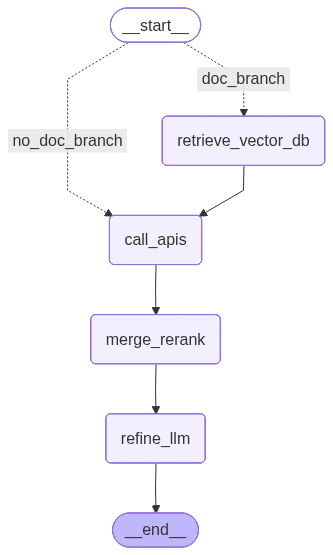

In [6]:
# @title Define Conditional Edges and Build the Graph (No Changes Here)
from langgraph.graph import END, StateGraph, START

# --- 1. DEFINE CONDITIONAL EDGE FOR INITIAL ROUTING ---
def route_query(state: GraphState) -> str:
    """
    The main router that decides the workflow path based on whether a document
    was part of the initial context.
    """
    print("---(Router): Deciding initial path...---")
    if state["doc_uploaded"]:
        print("---(Router): Path -> Doc Branch (Vector DB + APIs)---")
        return "doc_branch"
    else:
        print("---(Router): Path -> No-Doc Branch (Only APIs)---")
        return "no_doc_branch"



# --- 3. BUILD THE GRAPH ---
graph_builder = StateGraph(GraphState)

# Add all the nodes to the graph
graph_builder.add_node("retrieve_vector_db", retrieve_from_vector_db)
graph_builder.add_node("call_apis", call_apis)
graph_builder.add_node("merge_rerank", merge_and_rerank)
graph_builder.add_node("refine_llm", refine_with_llm)

# Set the entry point router
graph_builder.add_conditional_edges(
    START,
    route_query,
    {
        "doc_branch": "retrieve_vector_db",
        "no_doc_branch": "call_apis",
    },
)

# Connect the nodes for the 'Doc Branch'
graph_builder.add_edge("retrieve_vector_db", "call_apis")
graph_builder.add_edge("call_apis", "merge_rerank")
graph_builder.add_edge("merge_rerank", "refine_llm")
graph_builder.add_edge("refine_llm", END)


# Compile the graph
app = graph_builder.compile()

# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not generate graph visualization: {e}")

In [7]:
# @title Run Scenario 1: Doc Branch with Human-in-Loop
from pprint import pprint

# Input for the graph
inputs_doc_branch = {
    "question": "How does the radical separation of law and religion contribute to the integrity crisis in Western civilization, and can reintegrating their underlying values restore societal cohesion without compromising secular governance?.",
    "doc_uploaded": True
}

print("Checking uploaded documents...")
print("If the answer is not found in the uploaded documents, I will fetch data by calling an API and provide results based on the LLM.")

print("\n--- Running Scenario 1: Doc Branch (FAISS + APIs) ---\n")
final_state_doc_branch = app.invoke(inputs_doc_branch, {"recursion_limit": 10})

print("\n\n--- FINAL GENERATION (Doc Branch) ---")
if isinstance(final_state_doc_branch.get('generation'), GenerationWithCitations):
    pprint(f"Answer: {final_state_doc_branch['generation'].answer}")
    print("\nCitations:")
    for citation in final_state_doc_branch['generation'].citations:
        pprint(f"- Source: {citation.source}, Description: {citation.description}, Link: {citation.link or 'N/A'}")
else:
    pprint(final_state_doc_branch.get('generation'))

Checking uploaded documents...
If the answer is not found in the uploaded documents, I will fetch data by calling an API and provide results based on the LLM.

--- Running Scenario 1: Doc Branch (FAISS + APIs) ---

---(Router): Deciding initial path...---
---(Router): Path -> Doc Branch (Vector DB + APIs)---
---(Node): Retrieving from Vector DB---


AttributeError: 'NoneType' object has no attribute 'invoke'

In [8]:
# @title Run Scenario 2: No-Doc Branch
from pprint import pprint

# Input for the graph
inputs_no_doc_branch = {
    "question": "How does the radical separation of law and religion contribute to the integrity crisis in Western civilization, and can reintegrating their underlying values restore societal cohesion without compromising secular governance?",
    "doc_uploaded": False
}

print("\n--- Running Scenario 2: No-Doc Branch (APIs only) ---\n")
final_state_no_doc_branch = app.invoke(inputs_no_doc_branch, {"recursion_limit": 10})

print("\n\n--- FINAL GENERATION (No-Doc Branch) ---")
if isinstance(final_state_no_doc_branch.get('generation'), GenerationWithCitations):
    pprint(f"Answer: {final_state_no_doc_branch['generation'].answer}")
    print("\nCitations:")
    for citation in final_state_no_doc_branch['generation'].citations:
        pprint(f"- Source: {citation.source}, Description: {citation.description}, Link: {citation.link or 'N/A'}")
else:
    pprint(final_state_no_doc_branch.get('generation'))


--- Running Scenario 2: No-Doc Branch (APIs only) ---

---(Router): Deciding initial path...---
---(Router): Path -> No-Doc Branch (Only APIs)---
---(Node): Calling External APIs---
---(API Call): Calling Google Search (Kannon API Stand-in)---
---(API Call): Calling Wikipedia API---
Combined 8 unique documents before reranking.
---(Rerank): Reranking 8 documents for top 5---
Selected top 5 documents after reranking.
---(Node): Refining with LLM and Generating Citations---
---(LLM Generation with Citations):---
Structured output generated successfully.
Answer: The provided documents do not contain sufficient information to answer the question about the radical separation of law and religion, its contribution to the integrity crisis in Western civilization, and the potential for reintegration to restore societal cohesion without compromising secular governance.
Citations:


--- FINAL GENERATION (No-Doc Branch) ---
('Answer: The provided documents do not contain sufficient information to